# The Regression Problem

## Instructions

-  We consider the dataset available at this [link](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data), provided by the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)

-  The dataset comes with a [**README**](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names) file, which contains information about the number of instances, the number and type of attributes, as well as the prediction goal.

-  To be able to work even without any network connection, I have stored both the dataset and README files locally on my machine.

-  "The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)

## Additional Notes

-  The original file contains a mixture of whitespace and tab-separated fields. In order to transform it into a legitimate tab-separated file, I had to run the following shell commands:

```bash
> TAB=$(printf '\t')
> sed "s/ \{2,\}/$TAB/g" < ${ORIGINAL_DATASET_FILE} > ${NEW_DATASET_FILE}
```

-  The commands above use <code>**sed**</code> to replace **2 or more** whitespaces with a tab character on **every line** of the original dataset file.

-  Linux and Mac OS X systems have <code>**sed**</code> natively installed. Windows users can install it from [here](http://gnuwin32.sourceforge.net/packages/sed.htm) 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import stats module from scipy, which contains a large number 
# of probability distributions as well as an exhaustive library of statistical functions.
import scipy.stats as stats

%matplotlib inline

# 1. Data Collection

In [2]:
# Path to the local dataset file
DATASET_PATH = "/Users/onuralpguvercin/Desktop/Padova Dersler/FIS python/lectures/auto-mpg-regression/dataset.tsv"

In [3]:
# Load the dataset with Pandas
data = pd.read_csv(DATASET_PATH, sep="\t")
print("Shape of the dataset: {}".format(data.shape))
data.head()
# NOTE: the first line of the file is considered as the header

Shape of the dataset: (397, 9)


,18.0,8,307.0,130.0,3504.,12.0,70,1,chevrolet chevelle malibu
0,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
1,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
2,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
3,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
4,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500


In [4]:
# Load the dataset with Pandas, this time taking into account
# the fact that there is no header line
data = pd.read_csv(DATASET_PATH, sep="\t", header=None)
print("Shape of the dataset: {}".format(data.shape))
data.head()

Shape of the dataset: (398, 9)


,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [5]:
# Column names (labels) are not so meaningful and we should use the attribute names
# provided in the README file
# Row index, instead, can be left as it is (i.e., default IndexRange)
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
           'acceleration', 'model_year', 'origin', 'car_name']
data = pd.read_csv(DATASET_PATH, sep="\t", header=None, names=columns)
print("Shape of the dataset: {}".format(data.shape))
data.head()

Shape of the dataset: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Checking for any Missing Values

In [6]:
# Check if there is any missing value in the whole dataset
print("There are missing values in the dataset: {}".
     format(data.isnull().any().any()))

There are missing values in the dataset: False


In [7]:
data.isnull().any().any()

False

In [8]:
# Check if 'horsepower' has really 6 missing values
print("N. of missing values for attribute 'horsepower': {}".
     format(data.horsepower.isnull().sum()))

N. of missing values for attribute 'horsepower': 0


In [9]:
# Weird... we know from the README file there must be 6 missing values
# How come we are not able to spot those?
# Possibly, because of the way in which NAs are 'encoded' in the file...
# Let's see the set of values contained in the 'horsepower' column
print(sorted(data.horsepower.unique(), reverse=True))

['?', '98.00', '97.00', '96.00', '95.00', '94.00', '93.00', '92.00', '91.00', '90.00', '89.00', '88.00', '87.00', '86.00', '85.00', '84.00', '83.00', '82.00', '81.00', '80.00', '79.00', '78.00', '77.00', '76.00', '75.00', '74.00', '72.00', '71.00', '70.00', '69.00', '68.00', '67.00', '66.00', '65.00', '64.00', '63.00', '62.00', '61.00', '60.00', '58.00', '54.00', '53.00', '52.00', '49.00', '48.00', '46.00', '230.0', '225.0', '220.0', '215.0', '210.0', '208.0', '200.0', '198.0', '193.0', '190.0', '180.0', '175.0', '170.0', '167.0', '165.0', '160.0', '158.0', '155.0', '153.0', '152.0', '150.0', '149.0', '148.0', '145.0', '142.0', '140.0', '139.0', '138.0', '137.0', '135.0', '133.0', '132.0', '130.0', '129.0', '125.0', '122.0', '120.0', '116.0', '115.0', '113.0', '112.0', '110.0', '108.0', '107.0', '105.0', '103.0', '102.0', '100.0']


In [10]:
# Apparently, there are some question mark characters '?' in this column.
# Let's see how many records have '?' in their 'horsepower' column.
# Extract the sub-DataFrame using boolean indexing 
# on the 'horsepower' column and count the corresponding number of matching rows.
print("How many records have 'horsepower=?'?: {}"
      .format(data[data.horsepower == '?'].shape[0]))

How many records have 'horsepower=?'?: 6


In [11]:
data[data.horsepower == '?'].shape[0]

6

In [12]:
data.loc[data.horsepower == "?", :]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [13]:
# We have therefore found that '?' is a sentinel value used to identify NAs
# Let's reload the dataset using this value as a marker for NAs.
data = pd.read_csv(DATASET_PATH, sep="\t", header=None, 
                   names=columns,
                   na_values={'horsepower':'?'})

# Alternatively, we could simply replace '?' on the loaded dataset with np.nan
# 1. Using 'loc':
# data.loc[data.horsepower == '?', 'horsepower'] = np.nan
# 2. Using 'replace':
# data.horsepower.replace('?', np.nan, inplace=True)
print("Shape of the dataset: {}".format(data.shape))
data.head()

Shape of the dataset: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [14]:
# Let's repeat the same check as above on missing values.
# Check if there is any missing value in the whole dataset
print("There are missing values in the dataset: {}".
     format(data.isnull().any().any()))
# Check if 'horsepower' has really 6 missing values
print("N. of missing values for attribute 'horsepower': {}".
     format(data.horsepower.isnull().sum()))

There are missing values in the dataset: True
N. of missing values for attribute 'horsepower': 6


In [15]:
# Let's have a look at the output of the 'describe()' function.
data.describe(include='all')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ford pinto
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864,NaN
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055,NaN
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,NaN
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000,NaN
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000,NaN
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,NaN


## Change the Column Layout

In [16]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data.columns.tolist()
print("Orignal order of columns:\n{}".format(columns))

# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))

print("New order of columns:\n{}".format(columns))

Orignal order of columns:
['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
New order of columns:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name', 'mpg']


In [17]:
columns

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year',
 'origin',
 'car_name',
 'mpg']

In [18]:
# Let's refactor the DataFrame using this new column index
data = data.loc[:, columns]
data.head()
# Alternatively to 'loc' we can also use 'reindex()'
# data = data.reindex(columns=columns)
# data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,ford torino,17.0


In [19]:
data.loc[:, columns]

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,ford torino,17.0
...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl,27.0
394,4,97.0,52.0,2130.0,24.6,82,2,vw pickup,44.0
395,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage,32.0
396,4,120.0,79.0,2625.0,18.6,82,1,ford ranger,28.0


## Apply Some Simple Data Transformations

In [20]:
# Suppose we want to convert displacement unit from cubic inch to litre
# There is a useful conversion table which tells us how to do that.
# 1 cubic inch = 0.016387064 litre
CI_TO_LITRE = 0.016387064
data.displacement *= CI_TO_LITRE
data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,5.030829,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,5.735472,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,5.211086,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,4.981667,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,4.948893,140.0,3449.0,10.5,70,1,ford torino,17.0


# 2. Data Exploration

## 2.1 Analysis of Data Distributions: Continous Values

-  Let's start visualizing the distributions of the **5 continuous-valued** features:
    - <code>**displacement**</code>
    - <code>**horsepower**</code> (contains 6 <code>**NA**</code>s)
    - <code>**weight**</code>
    - <code>**acceleration**</code>

In [25]:
# Create a lambda function which will be applied to each entry
# of the numpy 2-D array of AxesSubplot objects
# x is a reference to an AxesSubplot object
y_labeler = lambda x: x.set_ylabel('density')

# np.vectorize() allows calling the function on each element
y_labeler = np.vectorize(y_labeler)

array([[Text(0, 0.5, 'density'), Text(0, 0.5, 'density')],
       [Text(0, 0.5, 'density'), Text(0, 0.5, 'density')]], dtype=object)

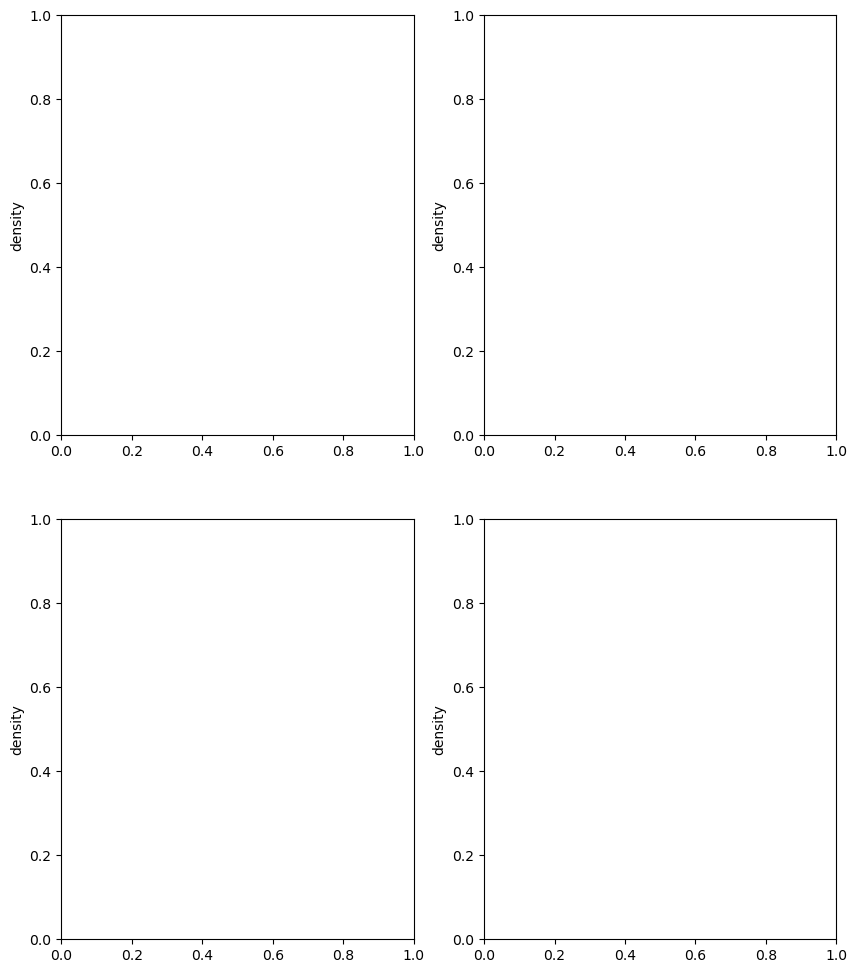

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10,12))
y_labeler(axes)
#y_labeler(axes)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

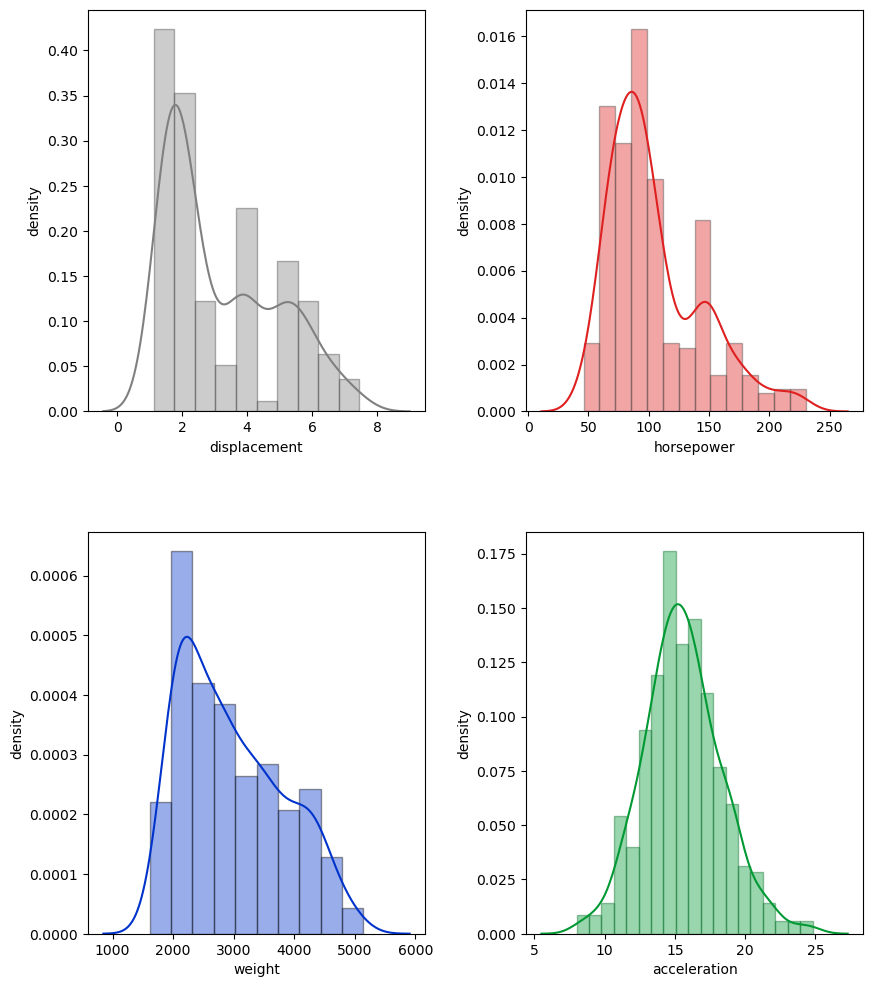

In [32]:
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10,12))

# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

# Plot 'displacement' on the top-left subplot
sns.distplot(data.displacement, color='#808080', ax=axes[0,0], 
                 hist_kws=dict(edgecolor="#404040", linewidth=1))

# Plot 'horsepower' (limited only to non-NA values) on the top-right subplot
sns.distplot(data.loc[data.horsepower.notnull(), 'horsepower'], 
                 color='#df2020', ax=axes[0,1], 
                 hist_kws=dict(edgecolor="#404040", linewidth=1))

# Plot 'weight' on the bottom-left subplot
sns.distplot(data.weight, color='#0033cc', ax=axes[1,0], 
                 hist_kws=dict(edgecolor="k", linewidth=1))

# Plot 'acceleration' on the bottom-right subplot
sns.distplot(data.acceleration, color='#009933', ax=axes[1,1],
                 hist_kws=dict(edgecolor="#006622", linewidth=1))

# Adjust space between plots
plt.subplots_adjust(wspace=.3, hspace=.3)

## Additional Note on Binning

-  If we don't specify the number of **bins** as argument of <code>**sns.distplot**</code> function (i.e.,<code>**bins=None**</code>) the **Freedman-Diaconis** rule is used to devise the _best_ number of bins.

-  This rule starts from defining the **width** each bin should have on the basis of the range of values observed, as follows:

$$
\texttt{bin}\_\texttt{width} = 2 * \frac{\texttt{IQR}}{n^{1/3}}
$$
where $\texttt{IQR}$ stands for **interquartile range**, namely the length of the interval delimited by the 1st and the 3rd quartile, and $n$ is the **number of observations**.

-  Finally, the number of bins is computed as:

$$
\texttt{bins} = (max−min)/\texttt{bin}\_\texttt{width}
$$

where, $max$ ($min$) is the **maximum** (**minimum**) value observed.


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/si

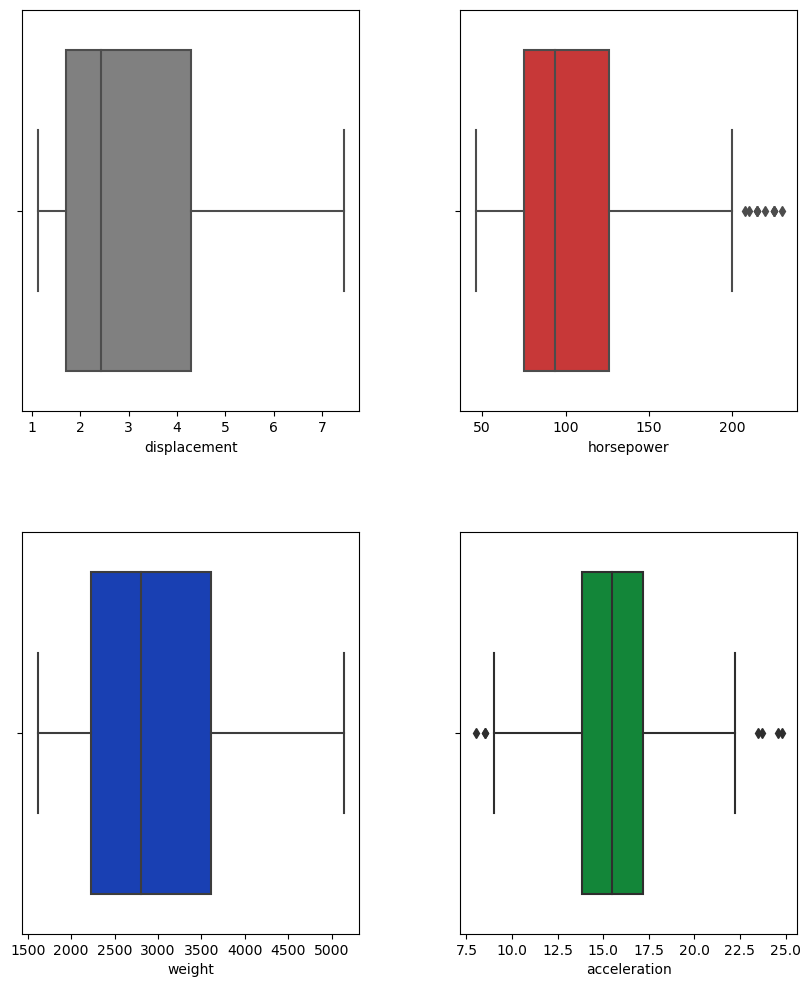

In [33]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10,12))

sns.boxplot(data.displacement, color='#808080', ax=axes[0,0])
sns.boxplot(data.loc[data.horsepower.notnull(), 'horsepower'], 
                color='#df2020', ax=axes[0,1])
sns.boxplot(data.weight, color='#0033cc', ax=axes[1,0])
sns.boxplot(data.acceleration, color='#009933', ax=axes[1,1])
plt.subplots_adjust(wspace=.3, hspace=.3)

## Spotting Outliers

-  Generally speaking, an outlier is an observation that is numerically distant from the rest of the data. 

-  Boxplots are useful to actually spot any possible **outlier**, as they show the distribution of values that are located within the $\texttt{IQR}$ (i.e., any data point between the 1st and 3rd quartile).

-  A boxplot defines also 2 other values, called **fences** or **whiskers** which are used to define outliers (i.e., any data point that is located outside the fences).

-  Usually, fences are determined as follows: if $Q_1$ and $Q_3$ represents the 1st and 3rd quartile, respectively, we define $F_\textrm{left}$ and $F_\textrm{right}$ as the left and right fence point, respectively, so that:

$$
F_\textrm{left} = Q_1 - 1.5 * \texttt{IQR};~~F_\textrm{right} = Q_3 + 1.5 * \texttt{IQR}
$$

## Few Observations from the Plots

-  <code>**displacement**</code> distribution is not uni-modal at all; in fact it is bi-, or possibly, tri-modal. Apparently, this is not affected by any outlier.

-  <code>**horsepower**</code> distribution is also not uni-modal, with a small bump around the value of 150Hp. However, here we can spot some possible outliers (i.e., large values over 200Hp).

-  <code>**weight**</code> distribution is uni-modal yet **right-skewed** (**positively skewed**), which means the mean is shifted to the right due to the presence of some large values towards the positive direction (not necessarily outliers).

-  <code>**acceleration**</code> essentially fits nicely to a **Normal** (**Gaussian**) **distribution** and contains some outliers.

In [35]:
# Check how many outliers we have
# 1. 'horsepower'
hp_q1, hp_q3 = data.loc[data.horsepower.notnull(), 'horsepower'].quantile([.25, .75])
print("1st Quartile of 'horsepower': {:.2f}".
      format(hp_q1))
print("3rd Quartile of 'horsepower': {:.2f}".
      format(hp_q3))
hp_IQR = (hp_q3 - hp_q1)
print("IQR of 'horsepower': {:.2f}".
      format(hp_IQR))
hp_fence_left = hp_q1 - 1.5 * hp_IQR
hp_fence_right = hp_q3 + 1.5 * hp_IQR
print("Fence range: [{:.2f}, {:.2f}]".
      format(hp_fence_left, hp_fence_right))

1st Quartile of 'horsepower': 75.00
3rd Quartile of 'horsepower': 126.00
IQR of 'horsepower': 51.00
Fence range: [-1.50, 202.50]


In [36]:
print("N. of instances containing outlier of 'horsepower': {}".
      format(data[data.horsepower > hp_fence_right].shape[0]))

N. of instances containing outlier of 'horsepower': 10


In [37]:
# Check how many outliers we have
# 2. 'acceleration'
acc_q1, acc_q3 = data['acceleration'].quantile([.25, .75])
print("1st Quartile of 'acceleration': {:.2f}".
      format(acc_q1))
print("3rd Quartile of 'acceleration': {:.2f}".
      format(acc_q3))
acc_IQR = (acc_q3 - acc_q1)
print("IQR of 'acceleration': {:.2f}".
      format(hp_IQR))
acc_fence_left = acc_q1 - 1.5 * acc_IQR
acc_fence_right = acc_q3 + 1.5 * acc_IQR
print("Fence range: [{:.2f}, {:.2f}]".
      format(acc_fence_left, acc_fence_right))

1st Quartile of 'acceleration': 13.83
3rd Quartile of 'acceleration': 17.18
IQR of 'acceleration': 51.00
Fence range: [8.80, 22.20]


In [38]:
print("N. of instances containing outlier of 'horsepower' or 'acceleration': {}".
      format(data[(data.acceleration < acc_fence_left) | 
                  (data.acceleration > acc_fence_right)].shape[0]))

N. of instances containing outlier of 'horsepower' or 'acceleration': 7


In [39]:
print("N. of instances containing outlier of 'acceleration': {}".
      format(data[(data.horsepower > hp_fence_right) |
                  (data.acceleration > acc_fence_right) |
                  (data.acceleration < acc_fence_left)].shape[0]))

N. of instances containing outlier of 'acceleration': 16


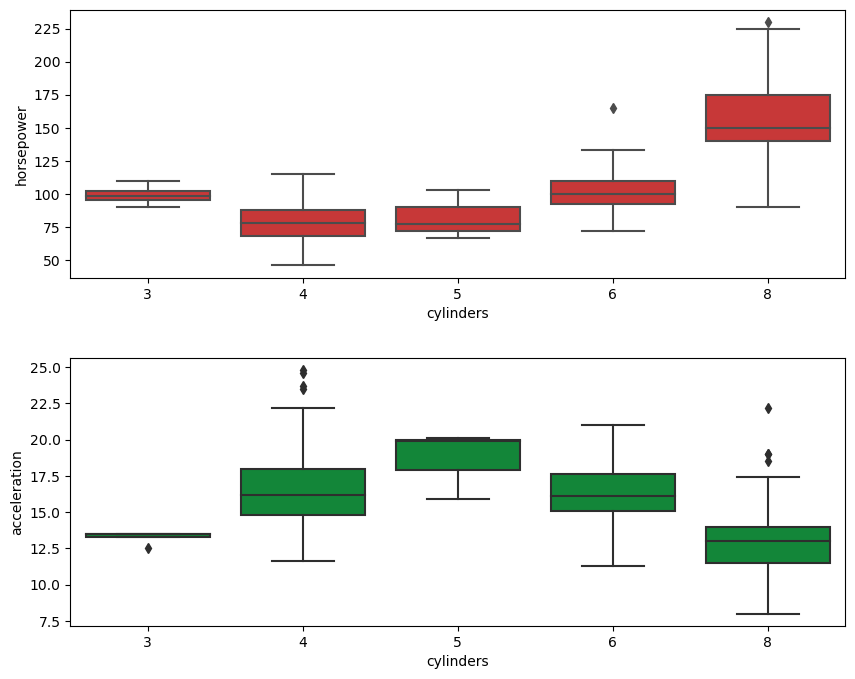

In [40]:
# Let's see if we can spot where those outliers are located
# w.r.t. other features (e.g., cylinders)
fig, axes = plt.subplots(2, 1, figsize=(10,8))

sns.boxplot(x=data.cylinders, y=data.loc[data.horsepower.notnull(), 'horsepower'], 
                color='#df2020', ax=axes[0])
sns.boxplot(x=data.cylinders, y=data.acceleration, color='#009933', ax=axes[1])
plt.subplots_adjust(wspace=.3, hspace=.3)

## Other Few Observations from the Plots

-  <code>**horsepower**</code>: outliers seem to occur only on 6- and 8-cylinder vehicles, stronger in the former.

-  <code>**acceleration**</code>: outliers here are more evenly distributed over 3- 4- and 8-cylinder vehicles.

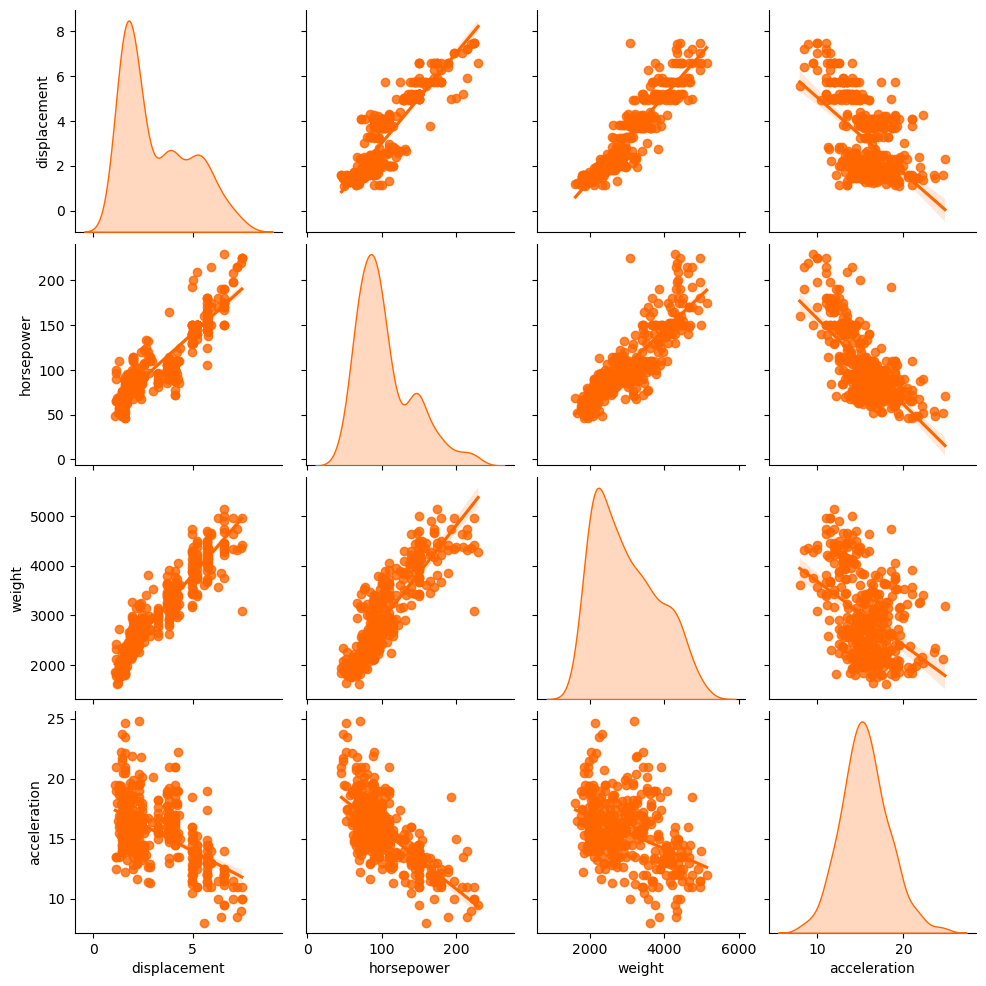

In [41]:
# Let's now plot the pairwise relationship between our continuous-valued features
sns.pairplot(data.loc[data.horsepower.notnull(),
                          ['displacement', 'horsepower', 'weight', 
                           'acceleration']],
                 kind="reg",
                 diag_kind='kde', 
                 diag_kws={'shade': True, 'color': '#ff6600'}, 
                 plot_kws={'color': '#ff6600'})

## How Continuous-valued Features Relate to Each Other

-  As <code>**displacement**</code> increases, so do <code>**weight**</code> and <code>**horsepower**</code>; also <code>**acceleration**</code> tends to decrease (pretty intuitive!).

-  As <code>**horsepower**</code> increases, <code>**acceleration**</code> decreases, whilst <code>**weight**</code> and <code>**displacement**</code> increase as well.

-  As <code>**weight**</code> increases, both <code>**horsepower**</code> and <code>**displacement**</code> increases but <code>**acceleration**</code> tends to decrease. Now, this might seem counterintuitive at first but the thing is that there might be a **latent factor** which affects this relationship (e.g., a heavy vehicle is also likely to have more horsepower and therefore this could be the actual reason why we observe such a phenomenon).

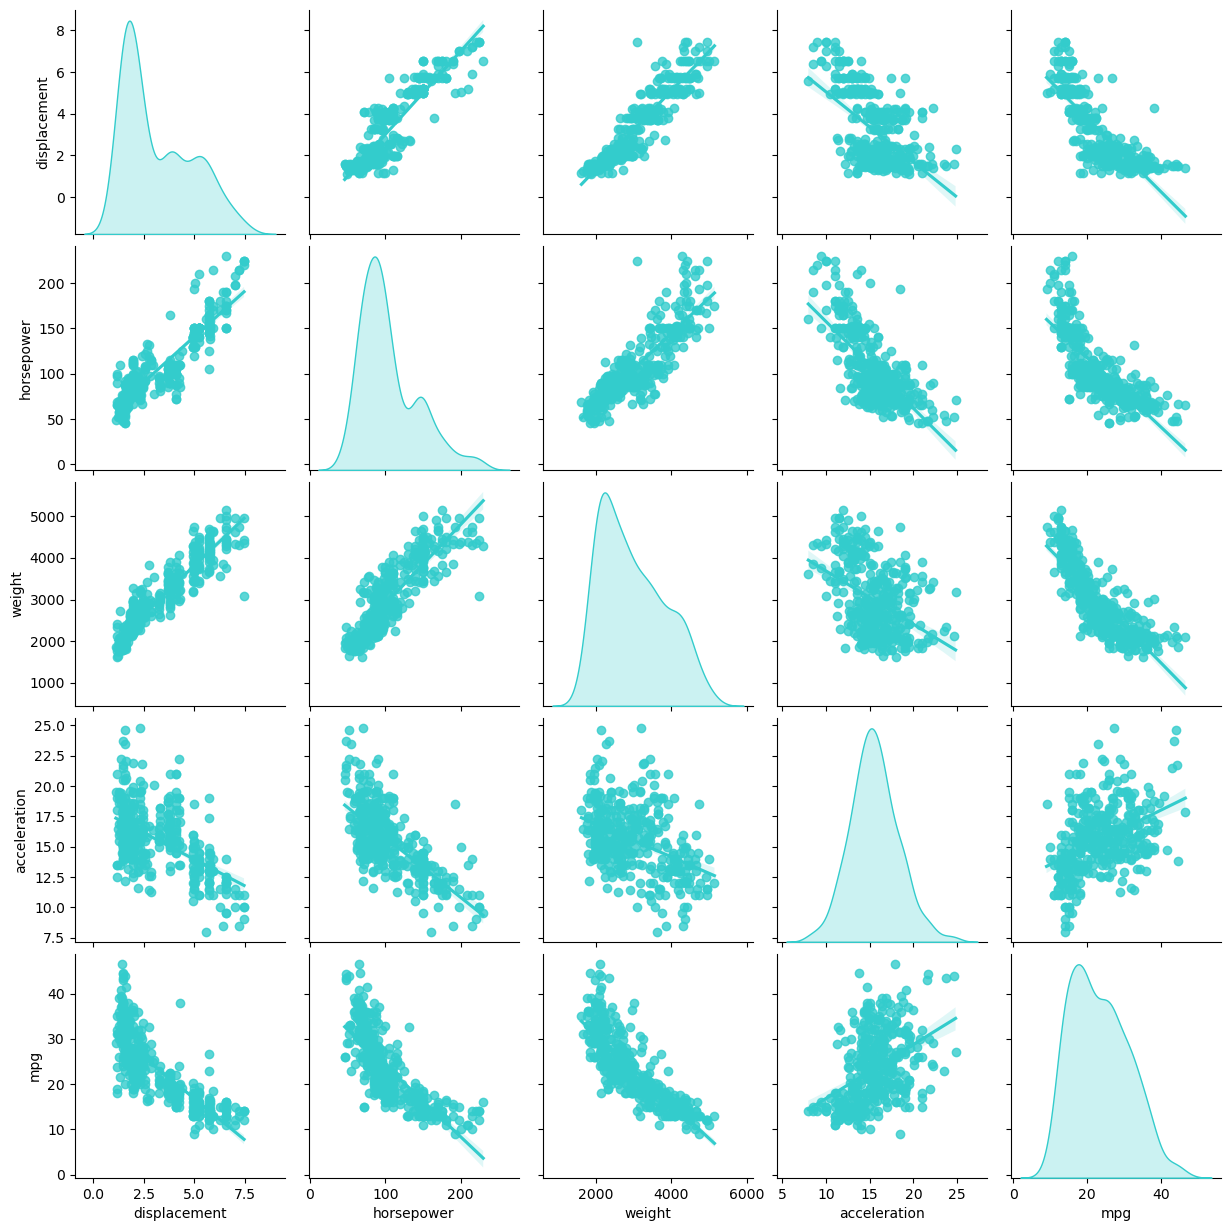

In [42]:
# Let's now plot the pairwise relationship between our continuous-valued features 
# this time also considering our target variable 'mpg'
sns.pairplot(data.loc[data.horsepower.notnull(),
                          ['displacement', 'horsepower', 'weight', 'acceleration', 'mpg']],
                 kind="reg",
                 diag_kind='kde', 
                 diag_kws={'shade': True, 'color': '#33cccc'}, 
                 plot_kws={'color': '#33cccc'})

## 2.1 Analysis of Data Distributions: Categorical Values

-  Let's visualize the distributions of the **3 categorical** features:
    - <code>**cylinders**</code>
    - <code>**model_year**</code>
    - <code>**origin**</code>

In [43]:
# Let's see the frequency counts of each categorical variable
# 'cylinders'
print(data.cylinders.value_counts())
print()
# 'model_year'
print(data.model_year.value_counts())
print()
# 'origin'
print(data.origin.value_counts())

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

73    40
78    36
76    34
82    31
75    30
70    29
79    29
80    29
81    29
71    28
72    28
77    28
74    27
Name: model_year, dtype: int64

1    249
3     79
2     70
Name: origin, dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


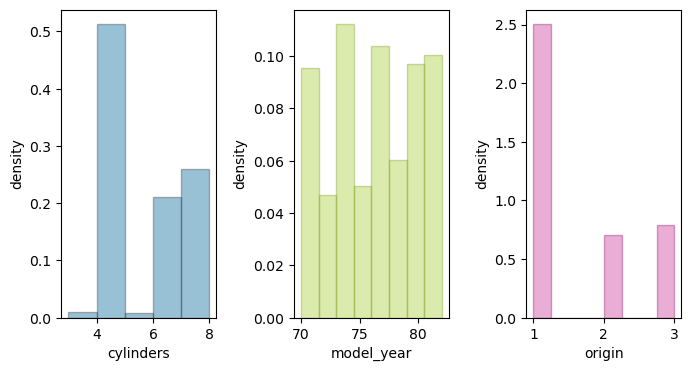

In [44]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(1, 3, figsize=(8,4))
y_labeler(axes)

# Plot 'cylinders'
sns.distplot(data.cylinders, color='#006699', ax=axes[0], 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#404040", linewidth=1))
# Plot 'model_year'
sns.distplot(data.model_year, color='#a6cc33', ax=axes[1], 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#85a329", linewidth=1))
# Plot 'origin'
sns.distplot(data.origin, color='#cc3399', ax=axes[2], 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#8f246b", linewidth=1))
# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


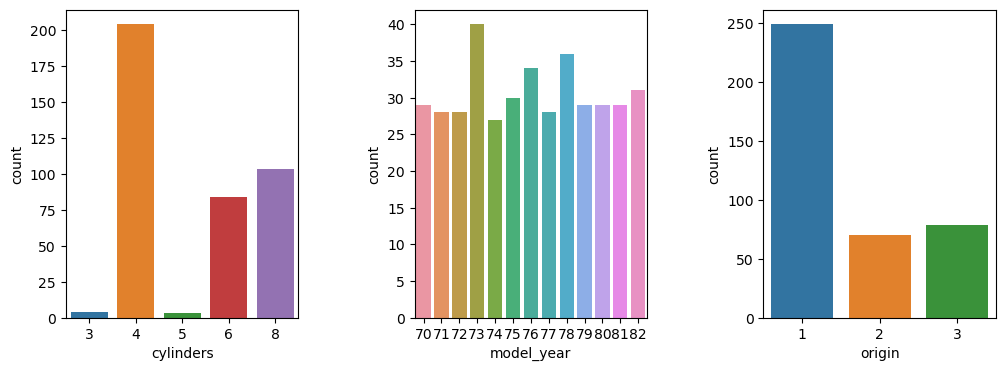

In [45]:
# For categorical variables, 'countplot' is the way to go
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Plot 'cylinders'
sns.countplot(data.cylinders, ax=axes[0])
sns.countplot(data.model_year, ax=axes[1])
sns.countplot(data.origin, ax=axes[2])
plt.subplots_adjust(wspace=.5, hspace=.4)

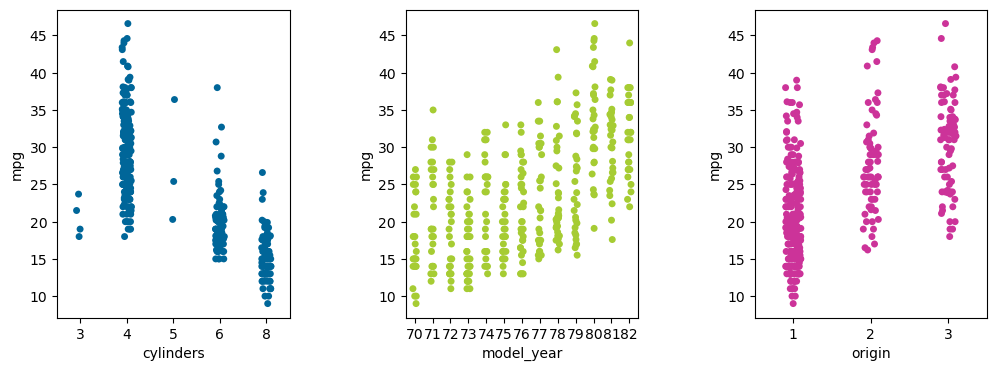

In [46]:
# stripplot is also another useful plot to relate categorical vs. target variable
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.stripplot(x=data.cylinders, y=data.mpg, color='#006699', ax=axes[0])
sns.stripplot(x=data.model_year, y=data.mpg, color='#a6cc33', ax=axes[1])
sns.stripplot(x=data.origin, y=data.mpg, color='#cc3399', ax=axes[2])

plt.subplots_adjust(wspace=.5, hspace=.3)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points 

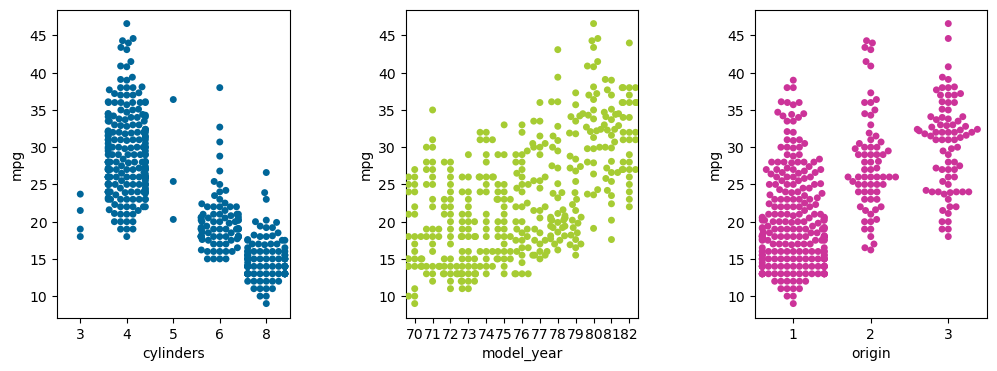

In [47]:
# swarmplot is also another useful plot to relate categorical vs. target variable
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.swarmplot(x=data.cylinders, y=data.mpg, color='#006699', ax=axes[0])
sns.swarmplot(x=data.model_year, y=data.mpg, color='#a6cc33', ax=axes[1])
sns.swarmplot(x=data.origin, y=data.mpg, color='#cc3399', ax=axes[2])

plt.subplots_adjust(wspace=.5, hspace=.3)

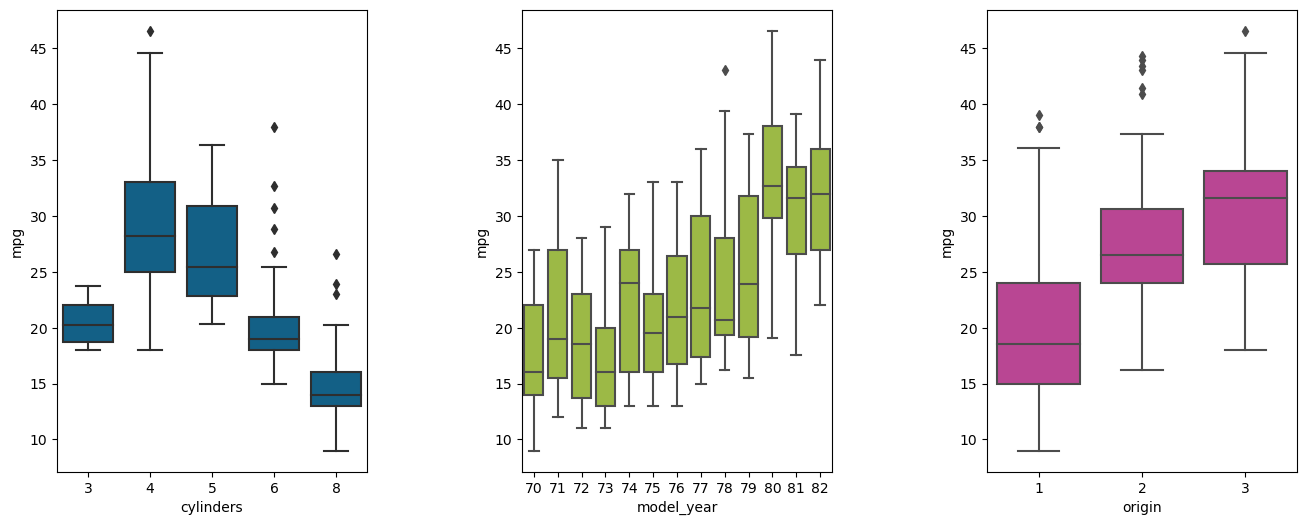

In [63]:
# boxplot is also another useful plot to relate categorical vs. target variable
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(16,6))

sns.boxplot(x=data.cylinders, y=data.mpg, color='#006699', ax=axes[0])
sns.boxplot(x=data.model_year, y=data.mpg, color='#a6cc33', ax=axes[1])
sns.boxplot(x=data.origin, y=data.mpg, color='#cc3399', ax=axes[2])

plt.subplots_adjust(wspace=.5, hspace=.3)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points 

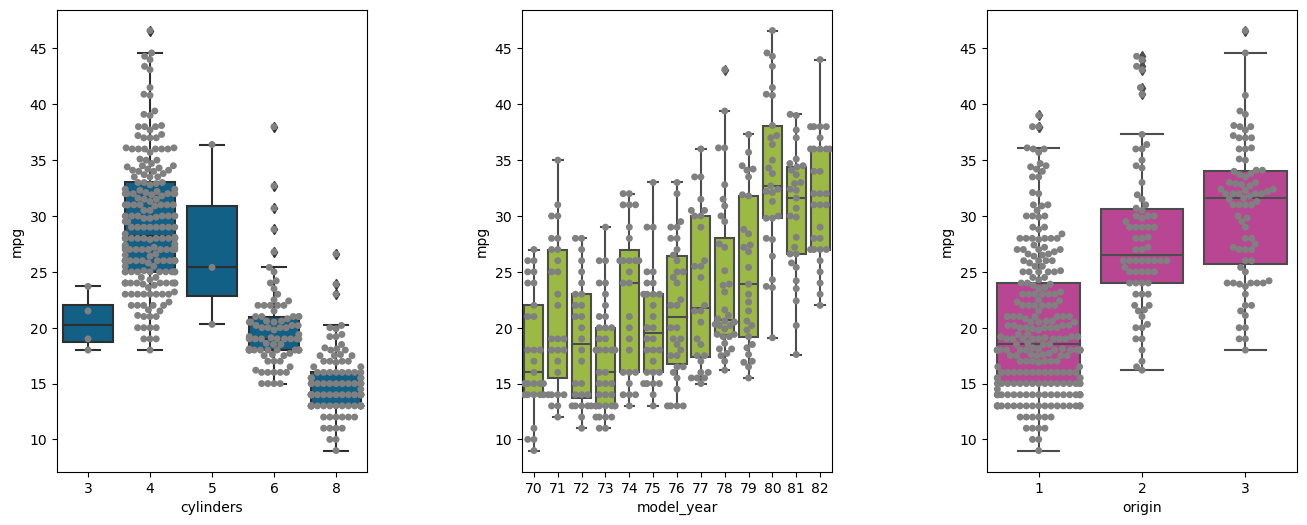

In [49]:
# Let's overlay boxplot and swarmplot
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(16,6))

sns.boxplot(x=data.cylinders, y=data.mpg, color='#006699', ax=axes[0])
sns.swarmplot(x=data.cylinders, y=data.mpg, color=".5", ax=axes[0])
sns.boxplot(x=data.model_year, y=data.mpg, color='#a6cc33', ax=axes[1])
sns.swarmplot(x=data.model_year, y=data.mpg, color=".5", ax=axes[1])
sns.boxplot(x=data.origin, y=data.mpg, color='#cc3399', ax=axes[2])
sns.swarmplot(x=data.origin, y=data.mpg, color=".5", ax=axes[2])

plt.subplots_adjust(wspace=.5, hspace=.3)

# 3. Data Preprocessing (Munging)

## Summary of the Issues

-  From our exploratory data analysis above, **two** main issues are observed:
    1. The presence of **6 missing values** for the attribute <code>**horsepower**</code>
    2. The presence of a total of **18 outliers** on the attributes <code>**horsepower**</code> and <code>**acceleration**</code>
-  In addition to those, we should also consider how to properly handle different feature's scale as well as the fact that we are in presence of both continuous and categorical attributes.

## 3.1 Handling Missing Values (NA)

-  There are just **6 out of 398** (i.e., approximately **1.5%**) of records containing a missing value.

-  Since they do not represent a significant subset of the whole dataset, we can simply drop those records.

-  Otherwise, we could mark (i.e., replace) those missing value using one of the strategies discussed (e.g., replace them with the median as computed from observed values).

In [50]:
# Let's go for the second option, i.e., replacing missing values on 'horsepower'
# using the median as computed from the other observations.
# NOTE: here's a classical example where using the mean rather than the median
# might affect the result, as the mean is more sensitive to outliers.
# NOTE: by default, median() does not include NAs in the computation.
# In other words, we don't need to explicitly tell pandas to work on non-NA values:
# data.horsepower[data.horsepower.notnull()].median()
data.horsepower.fillna(data.horsepower.median(), inplace=True)
data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,5.030829,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,5.735472,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,5.211086,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,4.981667,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,4.948893,140.0,3449.0,10.5,70,1,ford torino,17.0


In [51]:
data.describe(include='all')

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398,398.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ford pinto,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
mean,5.454774,3.169682,104.304020,2970.424623,15.568090,76.010050,1.572864,NaN,23.514573
std,1.701004,1.708677,38.222625,846.841774,2.757689,3.697627,0.802055,NaN,7.815984
min,3.000000,1.114320,46.000000,1613.000000,8.000000,70.000000,1.000000,NaN,9.000000
25%,4.000000,1.708351,76.000000,2223.750000,13.825000,73.000000,1.000000,NaN,17.500000
50%,4.000000,2.433479,93.500000,2803.500000,15.500000,76.000000,1.000000,NaN,23.000000
75%,8.000000,4.293411,125.000000,3608.000000,17.175000,79.000000,2.000000,NaN,29.000000


## 3.2 Handling Outliers

-  There are **18 outliers** shared between <code>**horsepower**</code> and <code>**acceleration**</code>.

-  Like missing values, outliers can be simply discarded as well (i.e., a process which is also known as **trimming** or **truncation**).

-  Another approach is called **winsorizing** and consists of replacing outliers with a specified percentile of the data (e.g., a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile).

In [52]:
# Python can winsorize data using 'scipy.stats' module.
# Example:
a = pd.Series([92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, -40, 101, 86, 85, 15, 89, 89, 28, -5, 41])
print("Length of a: {}".format(a.shape[0]))
print("Mean of a: {}".format(a.mean()))
print("Median of a: {}".format(a.median()))
print("Sorted a: {}".format(np.sort(a)))
q_005, q_95 = a.quantile([0.05, 0.95])
print("5th percentile of a: {:.2f}".format(q_005))
print("95th percentile of a: {:.2f}".format(q_95))
stats.mstats.winsorize(a, limits=0.05, inplace=True)
print("Sorted a: {}".format(np.sort(a)))

Length of a: 20
Mean of a: 101.5
Median of a: 68.0
Sorted a: [ -40   -5   10   13   15   19   26   28   41   58   78   85   86   89
   89   91   92  101  101 1053]
5th percentile of a: -6.75
95th percentile of a: 148.60
Sorted a: [ -5  -5  10  13  15  19  26  28  41  58  78  85  86  89  89  91  92 101
 101 101]


In [53]:
# Let's winsorize 'horsepower' and 'acceleration'
stats.mstats.winsorize(data.horsepower, limits=0.0375, inplace=True)
stats.mstats.winsorize(data.acceleration, limits=0.0375, inplace=True)

masked_array(data=[12. , 11.5, 11. , 12. , 11. , 11. , 11. , 11. , 11. ,
                   11. , 11. , 11. , 11. , 11. , 15. , 15.5, 15.5, 16. ,
                   14.5, 20.5, 17.5, 14.5, 17.5, 12.5, 15. , 14. , 15. ,
                   13.5, 18.5, 14.5, 15.5, 14. , 19. , 13. , 15.5, 15.5,
                   15.5, 15.5, 12. , 11.5, 13.5, 13. , 11.5, 12. , 12. ,
                   13.5, 19. , 15. , 14.5, 14. , 14. , 19.5, 14.5, 19. ,
                   18. , 19. , 20.5, 15.5, 17. , 21. , 19.5, 16.5, 12. ,
                   12. , 13.5, 13. , 11.5, 11. , 13.5, 13.5, 12.5, 13.5,
                   12.5, 14. , 16. , 14. , 14.5, 18. , 19.5, 18. , 16. ,
                   17. , 14.5, 15. , 16.5, 13. , 11.5, 13. , 14.5, 12.5,
                   11.5, 12. , 13. , 14.5, 11. , 11. , 11. , 16.5, 18. ,
                   16. , 16.5, 16. , 21. , 14. , 12.5, 13. , 12.5, 15. ,
                   19. , 19.5, 16.5, 13.5, 18.5, 14. , 15.5, 13. , 11. ,
                   19.5, 15.5, 14. , 15.5, 11. , 14

In [64]:
data.describe(include='all')

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398,398.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ford pinto,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
mean,5.454774,3.169682,103.761307,2970.424623,15.564322,76.010050,1.572864,NaN,23.514573
std,1.701004,1.708677,35.712003,846.841774,2.544987,3.697627,0.802055,NaN,7.815984
min,3.000000,1.114320,58.000000,1613.000000,11.000000,70.000000,1.000000,NaN,9.000000
25%,4.000000,1.708351,76.000000,2223.750000,13.825000,73.000000,1.000000,NaN,17.500000
50%,4.000000,2.433479,93.500000,2803.500000,15.500000,76.000000,1.000000,NaN,23.000000
75%,8.000000,4.293411,125.000000,3608.000000,17.175000,79.000000,2.000000,NaN,29.000000


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/si

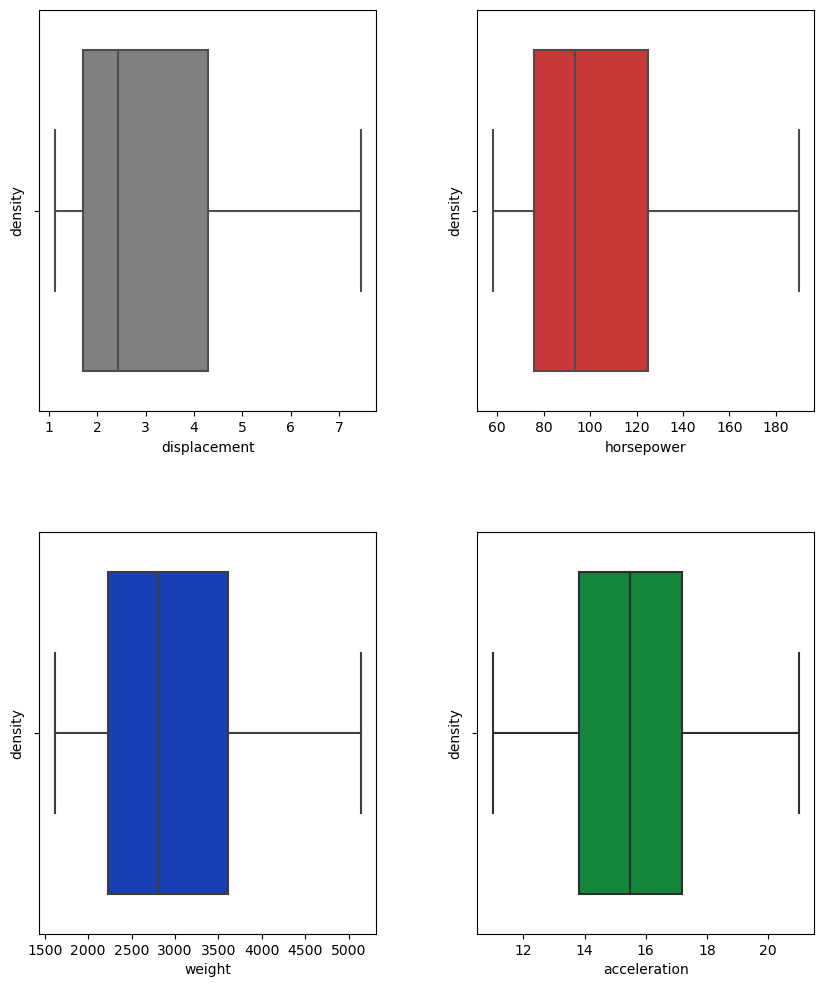

In [55]:
# Let's verify the outliers are actually gone
fig, axes = plt.subplots(2, 2, figsize=(10,12))
y_labeler(axes)
sns.boxplot(data.displacement, color='#808080', ax=axes[0,0])
sns.boxplot(data.horsepower, color='#df2020', ax=axes[0,1])
sns.boxplot(data.weight, color='#0033cc', ax=axes[1,0])
sns.boxplot(data.acceleration, color='#009933', ax=axes[1,1])
plt.subplots_adjust(wspace=.3, hspace=.3)

## 3.3 Encoding Categorical Features

-  Categorical variables are typically stored as text values which represent various traits. 

-  Some examples include <code>**color**</code> = {"Red", "Yellow", "Blue"), <code>**size**</code> =  ("Small", "Medium", "Large"), etc.

-  Many ML algorithms can support categorical values without further manipulation but there are many others that do not. 

-  Therefore, the analyst is faced with the challenge of figuring out how to turn these text attributes into **numerical values** for further processing.

## Approach 1: Label Encoding

-  Label encoding is simply converting each value in a column to a number. 

-  For example, the <code>**model_year**</code> column contains 13 different values. We could choose to encode it like this:

```python
70 --> 0
71 --> 1
72 --> 2
...
```

## Approach 2: One-Hot Encoding

-  Label encoding is straightforward but it has the disadvantage that numeric values can be "misinterpreted" by the learning algorithms. 

-  For example, the value of 0 is obviously less than the value of 4 but is that what we really aim for? For example, does a vehicle from 1974 have "4x" more weight than one from 1971?

-  A common alternative approach is called **one hot encoding**. Here, the basic strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. 

-  This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set.

In [65]:
# In pandas we can achieve easily one-hot encoding using the 'get_dummies()' function
categorical_features = ['cylinders', 'model_year', 'origin']
data_with_dummies = pd.get_dummies(data, columns = categorical_features)
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,mpg,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,model_year_76,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,18.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,15.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,18.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,16.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4.948893,140.0,3449.0,11.0,ford torino,17.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [66]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data_with_dummies.columns.tolist()
# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))
# Let's refactor the DataFrame using this new column index
data_with_dummies = data_with_dummies.loc[:, columns]
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,15.0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,16.0
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,17.0


In [67]:
# The categorical variable 'car_name' contains a lot of different values.
# Using one-hot encoding might lead to a very sparse dataset, as we need
# to map a single column to 305 columns!
data_with_dummies.car_name.value_counts()

ford pinto             6
toyota corolla         5
amc matador            5
ford maverick          5
chevrolet chevette     4
                      ..
chevrolet monza 2+2    1
ford mustang ii        1
pontiac astro          1
amc pacer              1
chevy s-10             1
Name: car_name, Length: 305, dtype: int64

In [68]:
"""
Three solutions can be designed to tackle with this issue:
1) Just drop the column 'car_name' (i.e., our model won't rely on that feature for prediction)
2) Use one-hot encoding scheme and deal with sparsity data (i.e., possibly leading to overfitting)
3) Trade-off: try to build another column which somehow reduces (i.e., cluster) similar values together
and then apply one-hot encoding.
Let's see how to perform 3)
"""
# Suppose we want to create another column called 'automaker_name', which simply contains
# the name of the automaker, disregarding the model.
# For example, automaker_name('ford gran torino') = automaker_name('ford f250') = 'ford'
data_with_dummies['automaker_name'] = data_with_dummies['car_name'].map(lambda x:
                                                                       x.split(' ')[0])
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg,automaker_name
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,chevrolet
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,1,0,0,15.0,buick
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,plymouth
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,1,0,0,16.0,amc
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,1,0,0,17.0,ford


In [69]:
data_with_dummies['car_name'].map(lambda x: x.split(' ')[0]).value_counts()

ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
saab              4
subaru            4
opel              4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: car_name, dtype: int64

In [70]:
"""
Let's see how many distinct values we have now for this nvalue_countsrical variable
"""
data_with_dummies['automaker_name'].value_counts()

ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
saab              4
subaru            4
opel              4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: automaker_name, dtype: int64

In [71]:
def sanitize_automaker_name(car_name):
    s = car_name.split(' ')[0]
    if s == 'vw' or s == 'vokswagen':
        return car_name.replace(s,'volkswagen')
    if s == 'chevroelt' or s == 'chevy':
        return car_name.replace(s,'chevrolet')
    if s == 'maxda':
        return car_name.replace(s,'mazda')
    if s == 'mercedes':
        return car_name.replace(s,'mercedes-benz')
    if s == 'toyouta':
        return car_name.replace(s,'toyota')
    return car_name

In [72]:
"""
Use the 'sanitize_automaker_name' function to update 'car_name' values.
"""
data_with_dummies['car_name'] = data_with_dummies['car_name'].map(lambda x:
                                                                 sanitize_automaker_name(x))
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg,automaker_name
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,chevrolet
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,1,0,0,15.0,buick
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,plymouth
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,1,0,0,16.0,amc
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,1,0,0,17.0,ford


In [73]:
"""
Re-apply the function on the sanitized version of 'car_name'.
"""
data_with_dummies['automaker_name'] = data_with_dummies['car_name'].map(lambda x: 
                                                                        x.split(' ')[0])
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg,automaker_name
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,chevrolet
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,1,0,0,15.0,buick
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,plymouth
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,1,0,0,16.0,amc
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,1,0,0,17.0,ford


In [74]:
"""
Let's see how many distinct values we have now for this new categorical variable.
"""
data_with_dummies['automaker_name'].value_counts()

ford             51
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
mercedes-benz     3
cadillac          2
bmw               2
capri             1
hi                1
triumph           1
nissan            1
Name: automaker_name, dtype: int64

In [75]:
# Create the set of the top-10 automakers
top_10_automakers = set(data_with_dummies['automaker_name'].value_counts().index[:10])
# Label with 'other' any automaker_name which is not in the list above
data_with_dummies['automaker_name'] = np.where(data_with_dummies.
                                               automaker_name.isin(top_10_automakers), 
                                               data_with_dummies.automaker_name,
                                              'other')

In [77]:
data.loc[data_with_dummies.automaker_name == 'other', 'car_name']

20                           peugeot 504
21                           audi 100 ls
22                              saab 99e
23                              bmw 2002
28                              hi 1200d
                     ...                
381                         honda accord
383                          honda civic
384                   honda civic (auto)
387    oldsmobile cutlass ciera (diesel)
388           chrysler lebaron medallion
Name: car_name, Length: 109, dtype: object

In [80]:
"""
Let's verify we did it right!
"""
data.loc[data_with_dummies.automaker_name == 'other', 'car_name'].map(lambda x: 
                                                                      x.split(' ')[0] not in top_10_automakers).all()



True

In [81]:
"""
We now categorize (i.e., discretize) 'automaker_name' using the 10 + 1 discrete values above.
"""
categorical_features = ['automaker_name']
data_with_dummies = pd.get_dummies(data_with_dummies, columns = categorical_features)
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,automaker_name_buick,automaker_name_chevrolet,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_other,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [82]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data_with_dummies.columns.tolist()
# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))
# Popping out 'automaker_name_other' from the list and insert it after 'automaker_name_volkswagen'.
columns.insert(columns.index('automaker_name_volkswagen'), columns.pop(columns.index('automaker_name_other')))
# Popping out 'car_name' from the list and insert it right before 'mpg'
columns.insert(-1, columns.pop(columns.index('car_name')))
# Let's refactor the DataFrame using this new column index
data_with_dummies = data_with_dummies.loc[:, columns]
data_with_dummies.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other,car_name,mpg
0,5.030829,130.0,3504.0,12.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,chevrolet chevelle malibu,18.0
1,5.735472,165.0,3693.0,11.5,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,buick skylark 320,15.0
2,5.211086,150.0,3436.0,11.0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,plymouth satellite,18.0
3,4.981667,150.0,3433.0,12.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,amc rebel sst,16.0
4,4.948893,140.0,3449.0,11.0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,ford torino,17.0


## 3.4 Standardize Feature Scale

-  Some learning models are sensitive to different feature scales appearing on the training dataset.

-  To overcome this issue, one typically standardize (i.e., normalize) the values of each continuous feature.

-  Two main strategies are usually enacted:
    -  **min-max** normalization
    -  **z-score** standardization

In [83]:
# Let's deep copy our DataFrame again
data_norm_0_1 = data_with_dummies.copy()

In [84]:
"""
The easiest way to normalize a (sub)set of features is as follows.
"""
# 1. Decide which list of features to standardize
features_to_standardize = ['displacement', 'horsepower', 'weight', 'acceleration']

# 2. Select those features (i.e., DataFrame columns) and apply, for example, min-max normalization
data_norm_0_1[features_to_standardize] = ((data_norm_0_1[features_to_standardize] - 
                                          data_norm_0_1[features_to_standardize].min()) 
                                          / (data_norm_0_1[features_to_standardize].max() - 
                                             data_norm_0_1[features_to_standardize].min()))
# 3. Verify the result
data_norm_0_1.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other,car_name,mpg
0,0.617571,0.545455,0.536150,0.10,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,chevrolet chevelle malibu,18.0
1,0.728682,0.810606,0.589736,0.05,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,buick skylark 320,15.0
2,0.645995,0.696970,0.516870,0.00,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,plymouth satellite,18.0
3,0.609819,0.696970,0.516019,0.10,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,amc rebel sst,16.0
4,0.604651,0.621212,0.520556,0.00,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,ford torino,17.0


In [85]:
# Let's make another deep copy of our DataFrame
data_std = data_with_dummies.copy()

In [86]:
"""
The following three functions are used to standardize/normalize features.
"""
# 1. z_score computes the standard z-score of a feature value x
def z_score(x, mu_X, sigma_X):
    return (x - mu_X)/sigma_X

# 2. min_max computes the normalized value of a feature value x in the range [-1, 1]
def min_max(x, X_min, X_max):
    return (2*x - X_max - X_min)/(X_max - X_min)

# 3. min_max_0_1 computes the normalized value of a feature value x in the range [0, 1]
def min_max_0_1(x, X_min, X_max):
    return (x - X_min)/(X_max - X_min)

In [87]:
"""
We use 'map' to call the z_score function above element-wise
on each Series object: displacement, horsepower, weight, and acceleration.
"""
# 1.a. Compute the mean and std deviation of 'displacement'
mu_displacement = data_std.displacement.mean()
sigma_displacement = data_std.displacement.std()
# 1.b. Call the z_score function on the 'displacement' Series
data_std.displacement = data_std.displacement.map(lambda x: 
                                                  z_score(x, mu_displacement, 
                                                          sigma_displacement))

# 2.a. Compute the mean and std deviation of 'horsepower'
mu_horsepower = data_std.horsepower.mean()
sigma_horsepower = data_std.horsepower.std()
# 2.b. Call the z_score function on the 'horsepower' Series
data_std.horsepower = data_std.horsepower.map(lambda x: 
                                              z_score(x, mu_horsepower, 
                                                      sigma_horsepower))

# 3.a. Compute the mean and std deviation of 'weight'
mu_weight = data_std.weight.mean()
sigma_weight = data_std.weight.std()
# 3.b. Call the z_score function on the 'weight' Series
data_std.weight = data_std.weight.map(lambda x: 
                                      z_score(x, mu_weight, 
                                              sigma_weight))

# 4.a. Compute the mean and std deviation of 'acceleration'
mu_acceleration = data_std.acceleration.mean()
sigma_acceleration = data_std.acceleration.std()
# 4.b. Call the z_score function on the 'acceleration' Series
data_std.acceleration = data_std.acceleration.map(lambda x: 
                                                  z_score(x, mu_acceleration, 
                                                          sigma_acceleration))

data_std.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other,car_name,mpg
0,1.089233,0.734730,0.630077,-1.400526,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,chevrolet chevelle malibu,18.0
1,1.501624,1.714793,0.853259,-1.596991,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,buick skylark 320,15.0
2,1.194728,1.294766,0.549778,-1.793456,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,plymouth satellite,18.0
3,1.060461,1.294766,0.546236,-1.400526,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,amc rebel sst,16.0
4,1.041280,1.014748,0.565130,-1.793456,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,ford torino,17.0


In [92]:
# Let's create yet another deep copy of our DataFrame
data_std_z = data_with_dummies.copy()

In [89]:
"""
This is an even more general solution for standardizing multiple features
in one shot, using customized "normalizing" functions.
"""
def standardized_continuous_features(dataset, feature_names, func=z_score):
    
    if func != z_score and func != min_max and func != min_max_0_1:
        func = z_score
            
    for feature in feature_names:
        print("Standardized feature \"{}\" using [{}] function".format(feature, func.__name__))
        if func == min_max or func == min_max_0_1:
            feature_min = dataset[feature].min()
            feature_max = dataset[feature].max()
            print("Min. = {}".format(feature_min))
            print("Max. = {}".format(feature_max))
            dataset[feature] = dataset[feature].map(lambda x: func(x, feature_min, feature_max))
        else:
            feature_mean = dataset[feature].mean()
            feature_std = dataset[feature].std()
            print("Mean = {}".format(feature_mean))
            print("Std. Deviation = {}".format(feature_std))
            dataset[feature] = dataset[feature].map(lambda x: func(x, feature_mean, feature_std))
    
    return dataset

In [93]:
"""
We call the function defined above on our deep copy, using the list of features
that needs to be standardized.
"""
data_std_z = standardized_continuous_features(data_std_z, features_to_standardize)
data_std_z.head()

Standardized feature "displacement" using [z_score] function
Mean = 3.169682264934676
Std. Deviation = 1.708676511381029
Standardized feature "horsepower" using [z_score] function
Mean = 103.76130653266331
Std. Deviation = 35.71200308064147
Standardized feature "weight" using [z_score] function
Mean = 2970.424623115578
Std. Deviation = 846.8417741973271
Standardized feature "acceleration" using [z_score] function
Mean = 15.564321608040187
Std. Deviation = 2.544987351982037


,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other,car_name,mpg
0,1.089233,0.734730,0.630077,-1.400526,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,chevrolet chevelle malibu,18.0
1,1.501624,1.714793,0.853259,-1.596991,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,buick skylark 320,15.0
2,1.194728,1.294766,0.549778,-1.793456,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,plymouth satellite,18.0
3,1.060461,1.294766,0.546236,-1.400526,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,amc rebel sst,16.0
4,1.041280,1.014748,0.565130,-1.793456,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,ford torino,17.0


In [94]:
"""
Let's verify the two different approaches above lead to the same result."
"""
print((np.abs(data_std[features_to_standardize] - data_std_z[features_to_standardize]) < 0.0001).all())

displacement    True
horsepower      True
weight          True
acceleration    True
dtype: bool


In [95]:
"""
Standardization and min-max scaling can be also performed using scikit-learn.
"""
# The following is the scikit-learn package which provides
# various preprocessing capabilities
from sklearn import preprocessing

# Standardizing features using z-score
std_scale = preprocessing.StandardScaler().fit(data_with_dummies[features_to_standardize])
data_std = std_scale.transform(data_with_dummies[features_to_standardize])

# Normalizing features using min-max
minmax_scale = preprocessing.MinMaxScaler().fit(data_with_dummies[features_to_standardize])
data_minmax = minmax_scale.transform(data_with_dummies[features_to_standardize])

# NOTE: 'data_std' and 'data_minmax' are numpy's ndarray (i.e., not pandas' DataFrame) objects

## 3.5 Feature Selection

-  This is a topic that would require an in-depth analysis.

-  A very simple approach to select highly discriminant features is given by measuring how each feature correlated with the target, and pick the ones with the highest correlation score.

In [96]:
"""
Let's compute feature correlation between each feature and our target 'mpg'.
Pandas 'corr()' function when applied to a DataFrame returns the whole correlation matrix.
This is a diagonal matrix having all 1's on its diagonal, whilst the entry (i,j) will contain
the correlation coefficient between feature i and feature j (i != j).
"""
corr_matrix = data_with_dummies.corr()
strong_corr = corr_matrix[(corr_matrix['mpg'].abs() > .5) &
                         (corr_matrix['mpg'] != 1)].loc[:, 'mpg']

print("Strongest correlated features:\n{}".
      format(strong_corr.sort_values()))
print()
print("Strongest correlated features (absolute values):\n{}".
      format(strong_corr.abs().sort_values(ascending=False)))

Strongest correlated features:
weight         -0.831741
displacement   -0.804203
horsepower     -0.788402
cylinders_8    -0.647308
origin_1       -0.568192
cylinders_4     0.758259
Name: mpg, dtype: float64

Strongest correlated features (absolute values):
weight          0.831741
displacement    0.804203
horsepower      0.788402
cylinders_4     0.758259
cylinders_8     0.647308
origin_1        0.568192
Name: mpg, dtype: float64
